<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/optimizacion_flujo_alimentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Optimización de flujo de alimentación $F_{in}$

Autor: Juan Manuel Gutiérrez García

Afiliación: Instituto Tecnológico de Morelia

Fecha: enero 2021

# Resumen

En el siguiente cuaderno describimos  la optimización de un biorreactor tipo lote-alimentado. En el proceso nos interesa maximizar la cantidad de biomasa generada al final de la fermentación. Se considera un flujo variable en la alimentación y una restricción en el volumen del biorreactor. El problema consiste en  encontrar el perfil de alimentación óptimo que nos permita maximizar la producción de biomasa en la fermentación. El análisis de hace con los parámetros óptimos obtenidos con datos de las levaduras *Isstchenkia terrícola*, *Kluyveromyces marxianus*, *Pichia kluyveri*, *Zygosaccharomyces bailii* y *Zygosaccharomyces rouxi* 

# Modelo con restricción de volumen

Las ecuaciones diferenciales que describen el proceso que se estudia son 

$$
\begin{aligned}
\frac{dV}{dt} &= F_{in} \\
\frac{dx}{dt} &= r_x - \frac{F_{in}}{V} x \\
\frac{ds}{dt} &= \frac{F_{in}}{V} (s_f - s) -\frac{1}{Y_{xs}}r_x \\
\frac{dp}{dt} &= Y_{px}r_x - \frac{F_{in}}{V} p
\end{aligned}
$$
Siendo

$$r_x = \mu_{max} \left( \frac{s}{k_s + s + k_i s^2} \right) x $$

Consideramos el caso en que el volumen del biorreactor tiene un límite, es decir, al momento de alimentar un flujo al biorreactor se debe considerar que este tiene una capacidad máxima y no es posible sobrepasar dicha capacidad. Por lo tanto, el flujo de alimentación al biorreactor se puede escribir como

$$\begin{equation*}
F_{in}(t) = \left\{
        \begin{array}{ll}
            F_{in} & \quad V \leq V_{lim} \\
            0 & \quad V > V_{lim}
        \end{array}
    \right.
\end{equation*}$$

# Establecer función objetivo

El problema de optimización aquí es maximizar la cantidad de biomasa al final de la fermentación. Por tanto, la función objetivo se puede formular de la siguiente manera:

$$max_{F_{in}(t)}\ J = x(t_f)V(t_f)$$
La optimización está sujeta a las restricciones

$$ 0 < F_{in}(t) < 2\ L/h$$
$$V(t_f) \leq 60\ L$$

Parámetros del algoritmo genético
Para el correcto funcionamiento del algoritmo genético usando la función ga() es necesario establecer un valor adecuado de los parámetros popSize, pcrossover, pmutation, elitism y maxiter. Además se deben establecer el valor mínimo y máximo para el parámetro a optimizar

Tabla 1. Valores de parámetros usados en la optimización

|parámetro|	valor|
|:---:|:---:|
|tamaño de población|	50|
|probabilidad de cruzamiento|	0.8|
|probabilidad de mutación|	0.1|
|elitismo|	2|
|número de generaciones (Fin constante)|	10|
|número de generaciones (Fin variable)|	100|

\\
Tabla 2. Valor mínimo y máximo de $F_{in}$

|parámetro|	mínimo|	máximo|
|:---:|:---:|:---:|
|$F{in} $ (L/h)|	0|	2|

Tabla 3. Parámetros de operación usados durante el análisis


|parámetro| valor|
|:---:|:---:|
$s_f$ | 50 g/L
$V_{lim}$ | 60 L
$t_f$ | 100 h
$x_0$ | 0.2 g/L
$s_0$ | 40 g/L
$p_0$ | 0 g/L
$V_0$ | 10 L

Tabla 4. Parámetros cinéticos de las cinco levaduras

|parámetro| IT | KM | PK | ZB | ZR | 	
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\mu_{max}$ (1/h)|2.410|2.308|2.291|2.021|1.465
|$k_s$ (g/L)|311.651|342.040|333.910|347.062|362.378
|$k_i$ (L/g)|0.190|0.269|0.230|0.272|0.601
|$Y_{xs}$|0.089|0.066|0.0850|0.0564|0.193
|$Y_{px}$|8.577|9.552|5.044|10.397|3.266
              

In [1]:
# instalar paquetes 
install.packages("deSolve")
install.packages("GA")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’, ‘RcppArmadillo’




In [2]:
# cargar librerías
library(deSolve)
library(ggplot2)
library(GA)

Loading required package: foreach

Loading required package: iterators

Package 'GA' version 3.2.1
Type 'citation("GA")' for citing this R package in publications.


Attaching package: ‘GA’


The following object is masked from ‘package:utils’:

    de




In [3]:
# @title establecer modelo con restricción
model <- function(times, state, parms) {
        with(as.list(c(state,parms)), {
                
                if (V > Vl) {

                        Fin = 0
                }
                
                # velocidad de crecimiento de biomasa
                rx = mu_max*s/(ks + s + ki*s^2)*x
                
                # velocidad de consumo de sustrato
                rs = (1/Yxs)*rx

                # velocidad de generación de producto
                rp = Ypx*rx
                
                # balance de material global 
                dVdt = Fin 
                
                # balance de materia para sustrato
                dsdt = Fin/V*(sf - s) - rs
                
                # balance de materia para biomasa
                dxdt = - Fin/V*x + rx
                
                # balance de materia para el producto
                dpdt = - Fin/V*p + rp

                return(list(c(dVdt, dsdt, dxdt, dpdt), Fin = Fin))
        })
}

In [4]:
#@title función para variar Fin durante el proceso, considerando la restricción V < Vl
change_input <- function(times, state, parms, Fin, model) {
        
        n <- length(times)
        # vectores para guardar los resultados
        V0 <- state[1]
        V <- rep(V0, n)
        s0 <- state[2]
        su <- rep(s0,n)
        x0 <- state[3]
        x <- rep(x0,n)
        p0 <- state[4]
        p <- rep(p0,n)
        
        # resolver EDO para los diferentes valores de Fin
        
        for (i in 1:(n-1)) {
                
                # actualizar tiempo de integración
                tspan <- c(times[i], times[i+1])
                
                # actualizar Fin
                parms["Fin"] <- Fin[i+1]
                
                # resolver EDOs
                out <- ode(y = state,
                           times = tspan,
                           func = model,
                           parms = parms,
                           method = "rk4")
                
                m <- nrow(out)
                # actualizar condiciones iniciales
                state <- out[m,c(2,3,4,5)]
                out <- as.data.frame(out)
                # guardar resultados 
                V[i+1] <- out$V[m]
                su[i+1] <- out$s[m]
                x[i+1] <- out$x[m]
                p[i+1] <- out$p[m]
                Fin[i+1] <- out$Fin[m]
        }
        
        return(list(times = times, V = V, s = su, x = x, p = p, Fin = Fin))
}

In [5]:
#@title función para obtener la biomasa final (función a optimizar)
biomass1 <- function(times, state, parms, model) {
        
        # simular proceso
        out <- ode(y = state, times = times, func = model, 
        parms = parms, method = "rk4")

        # obtener índice del estado final
        m <- nrow(out)

        # valor de estado al final de la simulación
        V_end <- out[m,2]
        x_end <- out[m,4]
        
        # calcular masas al final de la simulación
        mx_end <- V_end*x_end
        
        return(mx_end = mx_end)
}

In [6]:
#@title función para obtener la biomasa final para diferentes valores de Fin 
biomass2 <- function(times, state, parms, Fin, model) {
        
        # vectores para guardar los valores finales de mx
        n <- length(Fin)
        mx_end <- numeric(length = n)
        # ciclo for para evaluar todos los valores en Fin
        for (i in 1:n) {
                
                # actualizar valor de Fin
                parms["Fin"] <- Fin[i]
                
                # obtener valores finales final de mx
                out <- biomass1(times = times,state = state,parms = parms, model = model)
                
                # guardar mx final para Fin[i]
                mx_end[i] <- out
                
        }
        
        return(mx_end = mx_end)
}

### simulación con Fin variable

In [7]:
# tiempo de integración para la optimización
times <- seq(0,100,len=100)

In [8]:
# establecer parámetros arbitrarios para probar las funciones 
p <- c(mu_max = 1.2, ks = 280,  ki = 0.3, Yxs = 0.2, Ypx = 4, sf = 50, Fin = 1, Vl = 60)

In [9]:
# condiciones iniciales para la optimización
s <- c(V = 10.0, s = 40, x = 0.2, p = 0)

#Optimización con restricción de volumen

Para realizar las siguientes optimizaciones hacemos uso de algoritmos genéticos. Por esta razón es conveniente explicar la terminología empleada con estos algoritmos

Una solución candidata se denomina individuo. Una población denota un grupo de individuos.

El genotipo o cromosoma denota la representación de la estructura de datos individuales.

Un gen es el valor de una posición en tal representación y un alelo es un valor particular para un gen.

La función de evaluación se conoce como fitness y el fenotipo representa cómo opera el individuo durante la evaluación de la función fitness.

La creación de nuevas soluciones se denomina cría y se produce debido a la aplicación de operadores genéticos, como el cruce y la mutación.

Crossover implica la selección de soluciones de dos padres para generar hijos. La mutación realiza un ligero cambio en un individuo.

## Optimización manteniendo $F_{in}$ constante

In [10]:
# valores de Fin que vamos a investigar
Fin <- seq(0, 2, len = 100)

In [11]:
# @title función fitness para encontrar el flujo óptimo Fin de alimentación al biorreactor 
fitness1 <- function(x, times, state, parms, model) {
        # x es el flujo de alimentación Fin
        parms["Fin"] <- x
        # biomass1() regresa el valor de la biomasa final para el flujo de alimentación Fin 
        out <- biomass1(times = times, state = state, parms = parms, model = model)
        
        return(out)
}

In [12]:
# probar la función con Fin = 1
fitness1(x = 1, times = times, state = s, parms = p, model = model)

V 
542.2645

### Optimización de Fin para *Isstchenkia terrícola*

In [13]:
# parámetros cinéticos óptimos de IT y parámetros de operación establecidos
# ki = 0.190
p_it <- c(mu_max = 2.4102375, ks = 311.6519179, ki = 1.2, Yxs = 0.0897973, Ypx = 8.5770722, sf = 50, Fin = 1, Vl = 60)

In [14]:
# obtener biomasa final para todos los Fin
out_it_const <- biomass2(times = times, state = s, parms = p_it, Fin = Fin, model = model)

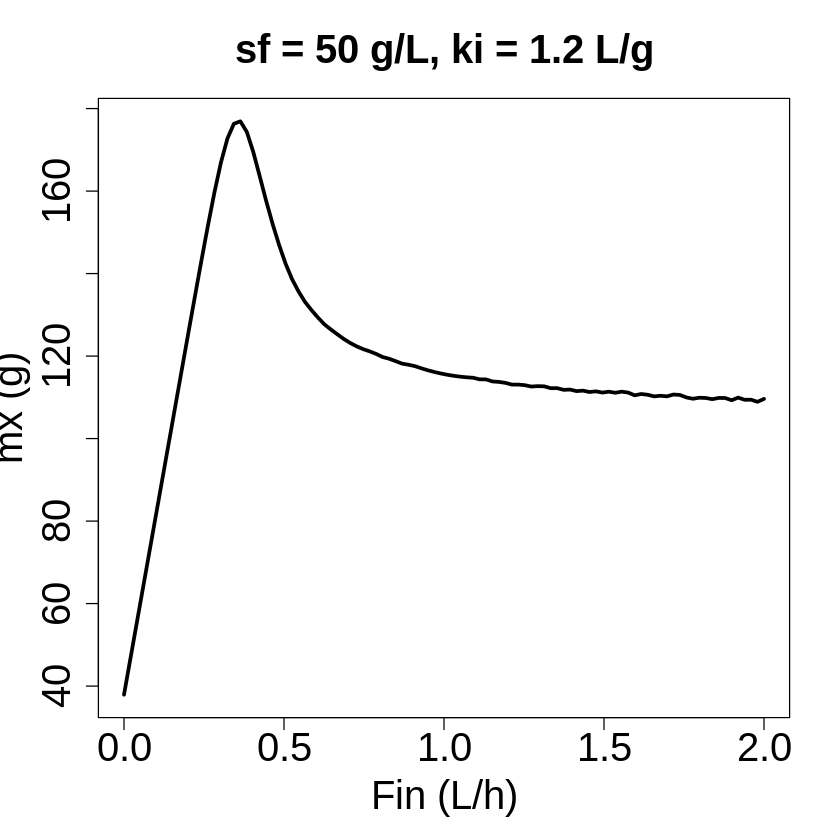

In [15]:
# mostrar función que se va a optimizar 
plot(Fin, out_it_const, ylab = "mx (g)", xlab = "Fin (L/h)", 
        main = paste0("sf = ", p_it["sf"], " g/L,", " ki = ", p_it["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 2, cex.main = 2, cex.axis = 2)

In [16]:
# optimización para encontrar el flujo de alimentación óptimo
set.seed(123)
GA_it_const <- ga(type = "real-valued",
         fitness = fitness1,
         times= times,
         state = s,
         parms = p_it,
         model = model,
         lower = 0,
         upper = 2,
         maxiter = 10, 
         popSize = 50, 
         elitism = 2)

In [17]:
# valor Fin que genera la máxima producción de biomasa 
cat("Fin_opt:", GA_it_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_it_const@fitnessValue, "g")

Fin_opt: 0.3572084  L/h 
mx_opt: 177.0786 g

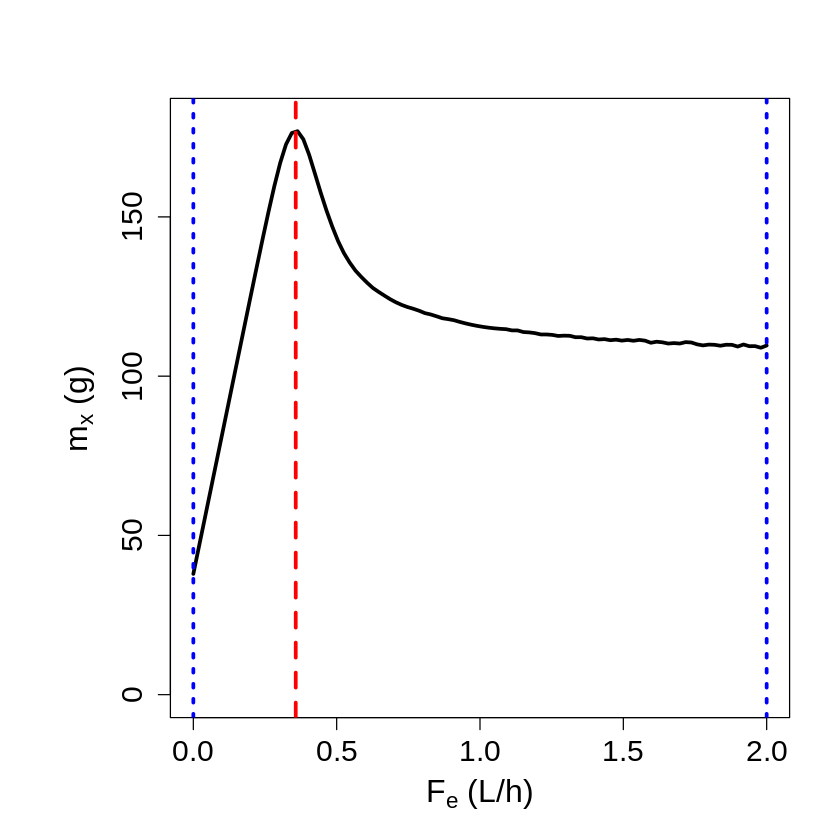

In [104]:
# mostrar resultados de la optimización
par(mar = c(5,7,4,2) + 0.1)
plot(Fin, out_it_const, ylab = expression(paste(m[x], " (g)")), xlab = expression(paste(F[e], " (L/h)")), 
        #main = paste0("sf = ", p_it["sf"], " g/L,", " ki = ", p_it["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,180))
abline(v = GA_it_const@solution, col="red", lwd = 3, lty = 2)
abline(v = c(0,2), col="blue", lwd = 3, lty = 3)

### Optimización de Fin para *Kluyveromyces marxianus*

In [19]:
# parámetros cinéticos óptimos de KM y parámetros de operación establecidos
# ki = 0.269
p_km <- c(mu_max = 2.30834, ks = 342.0408, ki = 1.2, Yxs = 0.06644916, Ypx = 9.552475, sf = 50, Fin = 1, Vl = 60)

In [20]:
# obtener biomasa final para todos los Fin
out_km_const <- biomass2(times = times, state = s, parms = p_km, Fin = Fin, model = model)

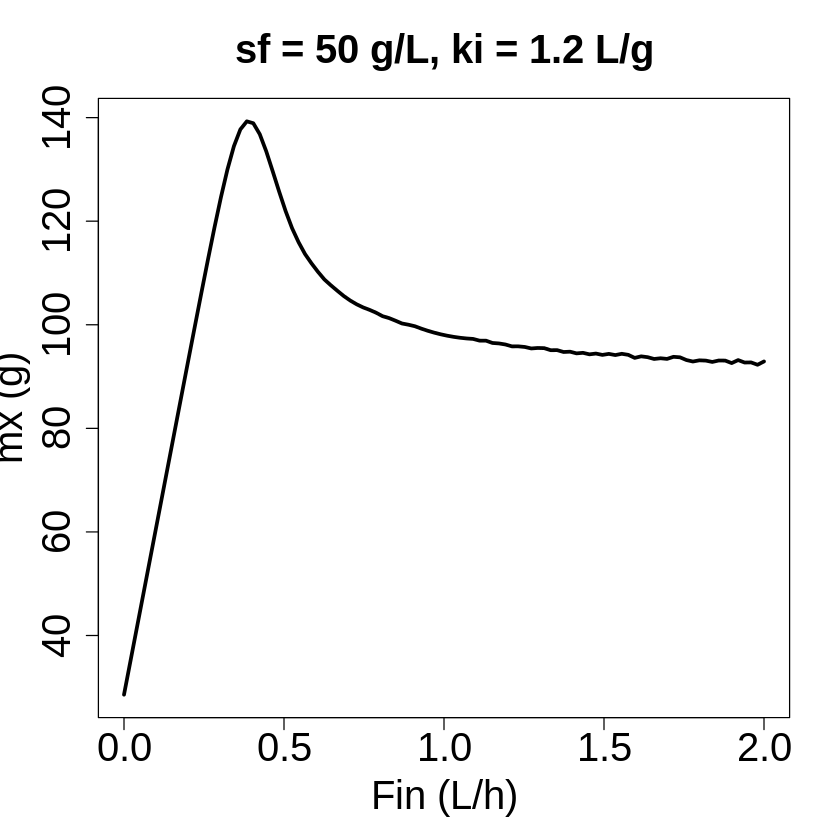

In [21]:
# mostrar función que se va a optimizar 
plot(Fin, out_km_const, ylab = "mx (g)", xlab = "Fin (L/h)", 
        main = paste0("sf = ", p_km["sf"], " g/L,", " ki = ", p_km["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 2, cex.main = 2, cex.axis = 2)

In [22]:
# optimización para encontrar el flujo de alimentación óptimo
set.seed(234)
GA_km_const <- ga(type = "real-valued",
         fitness = fitness1,
         times= times,
         state = s,
         parms = p_km,
         model = model,
         lower = 0,
         upper = 2,
         maxiter = 10, 
         popSize = 50, 
         elitism = 2)

In [23]:
# valor Fin que genera la máxima producción de biomasa 
cat("Fin_opt:", GA_km_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_km_const@fitnessValue, "g")

Fin_opt: 0.3900033  L/h 
mx_opt: 139.3746 g

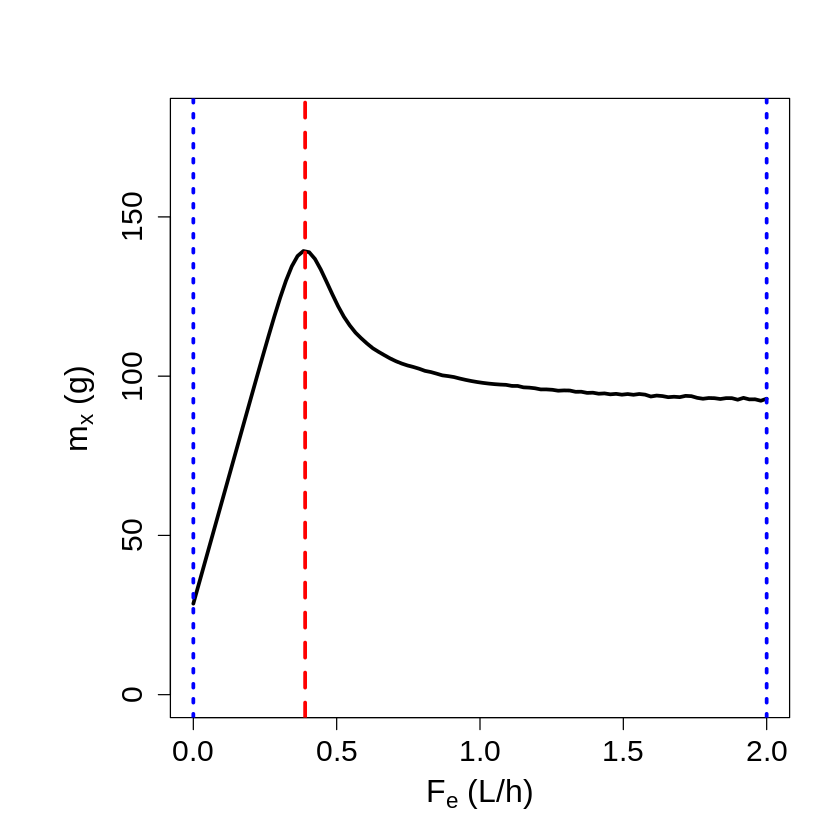

In [105]:
# mostrar resultados de la optimización
par(mar = c(5,7,4,2) + 0.1)
plot(Fin, out_km_const, ylab = expression(paste(m[x], " (g)")), xlab = expression(paste(F[e], " (L/h)")),   
        #main = paste0("sf = ", p_km["sf"], " g/L,", " ki = ", p_km["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,180))
abline(v = GA_km_const@solution, col="red", lwd = 3, lty = 2)
abline(v = c(0,2), col="blue", lwd = 3, lty = 3)

### Optimización de Fin para *Pichia kluyveri*

In [25]:
# parámetros cinéticos óptimos de PK y parámetros de operación establecidos
# ki = 0.230
p_pk <- c(mu_max = 2.291, ks = 333.910, ki = 1.2, Yxs = 0.0850, Ypx = 5.044, sf = 50, Fin = 1, Vl = 60)

In [26]:
# obtener biomasa final para todos los Fin
out_pk_const <- biomass2(times = times, state = s, parms = p_pk, Fin = Fin, model = model)

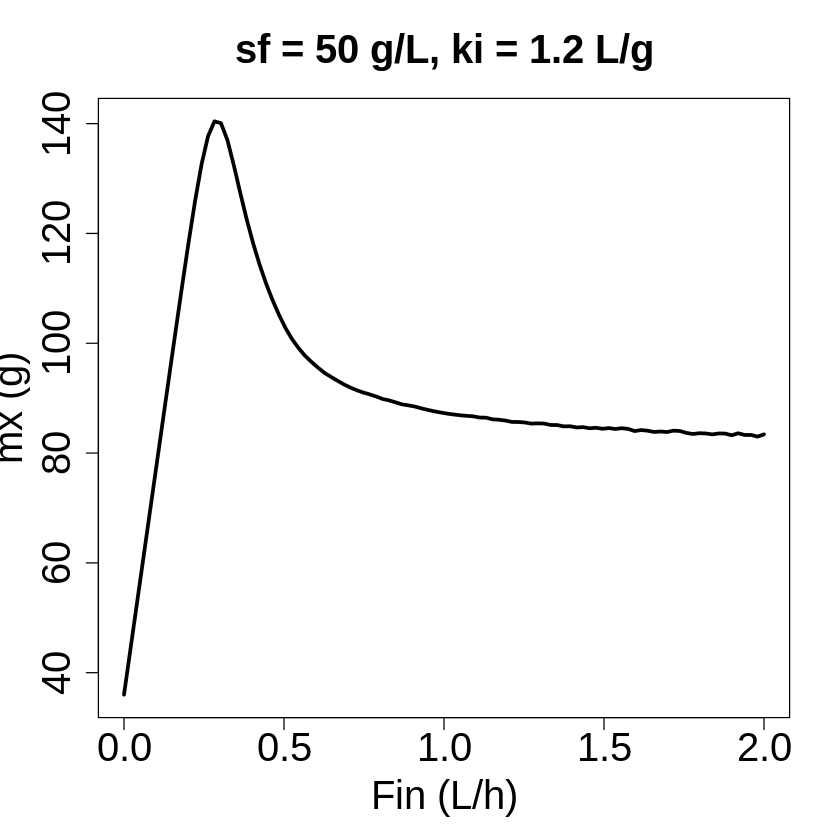

In [27]:
# mostrar función que se va a optimizar 
plot(Fin, out_pk_const, ylab = "mx (g)", xlab = "Fin (L/h)", 
        main = paste0("sf = ", p_pk["sf"], " g/L,", " ki = ", p_pk["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 2, cex.main = 2, cex.axis = 2)

In [28]:
# optimización para encontrar el flujo de alimentación óptimo
set.seed(345)
GA_pk_const <- ga(type = "real-valued",
         fitness = fitness1,
         times= times,
         state = s,
         parms = p_pk,
         model = model,
         lower = 0,
         upper = 2,
         maxiter = 10, 
         popSize = 50, 
         elitism = 2)

In [29]:
# valor Fin que genera la máxima producción de biomasa 
cat("Fin_opt:", GA_pk_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_pk_const@fitnessValue, "g")

Fin_opt: 0.2906421  L/h 
mx_opt: 140.6564 g

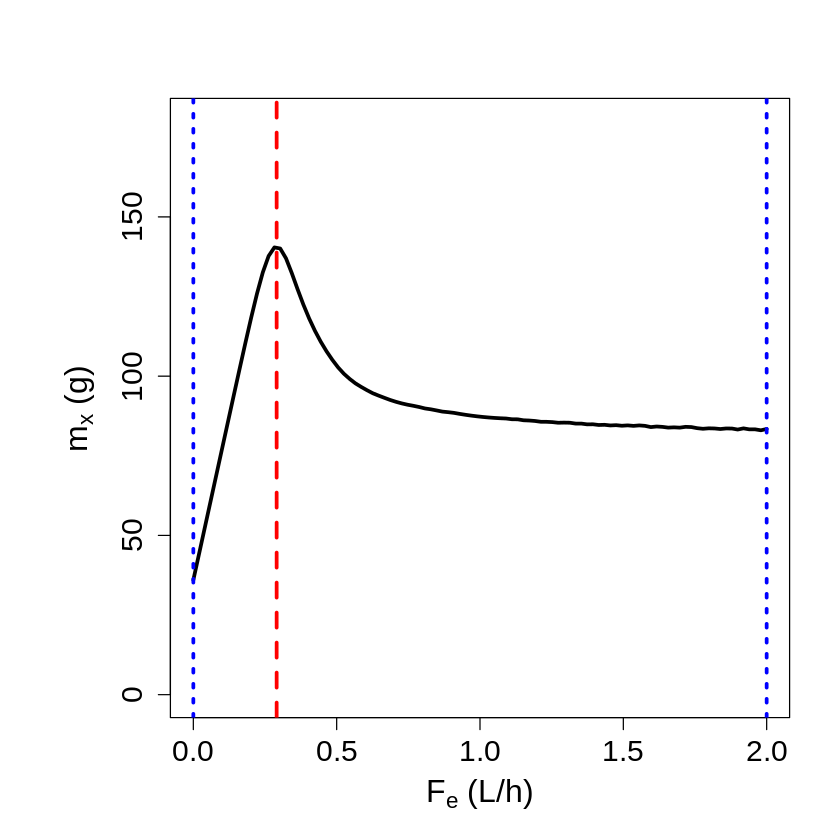

In [106]:
# mostrar resultados de la optimización
par(mar = c(5,7,4,2) + 0.1)
plot(Fin, out_pk_const, ylab = expression(paste(m[x], " (g)")), xlab = expression(paste(F[e], " (L/h)")), 
        #main = paste0("sf = ", p_pk["sf"], " g/L,", " ki = ", p_pk["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,180))
abline(v = GA_pk_const@solution, col="red", lwd = 3, lty = 2)
abline(v = c(0,2), col="blue", lwd = 3, lty = 3)

### Optimización de Fin para *Zygosaccharomyces bailii*

In [31]:
# parámetros cinéticos óptimos de ZB y parámetros de operación establecidos
# ki = 0.272
p_zb <- c(mu_max = 2.021993, ks = 347.0626, ki = 1.2, Yxs = 0.05646044, Ypx =  10.39769, sf = 50, Fin = 1, Vl = 60)

In [32]:
# obtener biomasa final para todos los Fin
out_zb_const <- biomass2(times = times, state = s, parms = p_zb, Fin = Fin, model = model)

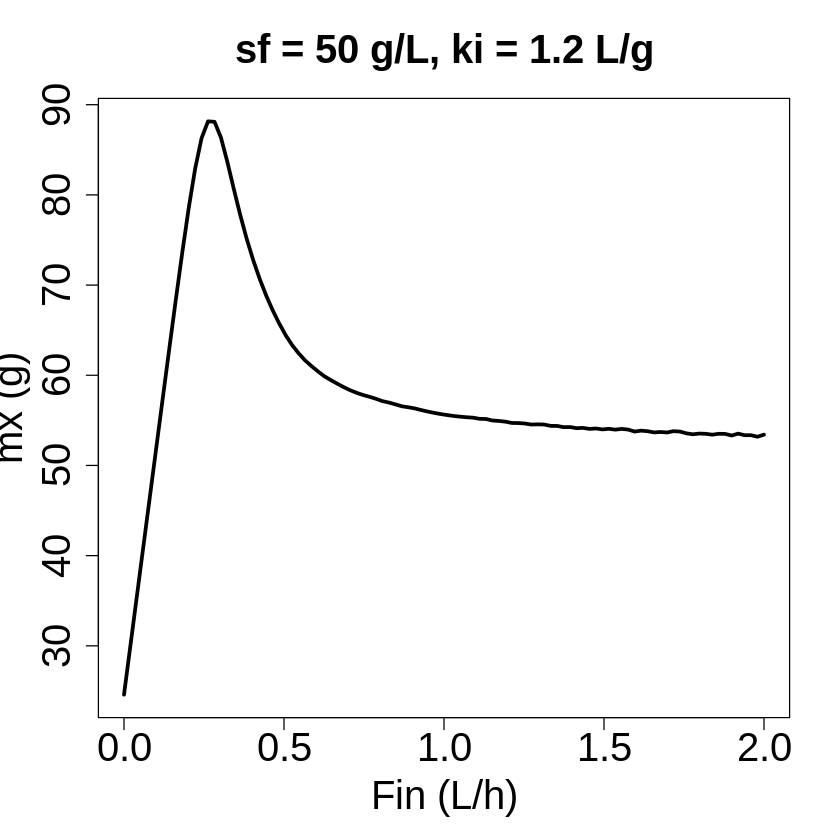

In [33]:
# mostrar función que se va a optimizar 
plot(Fin, out_zb_const, ylab = "mx (g)", xlab = "Fin (L/h)", 
        main = paste0("sf = ", p_zb["sf"], " g/L,", " ki = ", p_zb["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 2, cex.main = 2, cex.axis = 2)

In [34]:
# optimización para encontrar el flujo de alimentación óptimo
set.seed(456)
GA_zb_const <- ga(type = "real-valued",
         fitness = fitness1,
         times= times,
         state = s,
         parms = p_zb,
         model = model,
         lower = 0,
         upper = 2,
         maxiter = 10, 
         popSize = 50, 
         elitism = 2)

In [35]:
# valor Fin que genera la máxima producción de biomasa 
cat("Fin_opt:", GA_zb_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zb_const@fitnessValue, "g")

Fin_opt: 0.2720675  L/h 
mx_opt: 88.37581 g

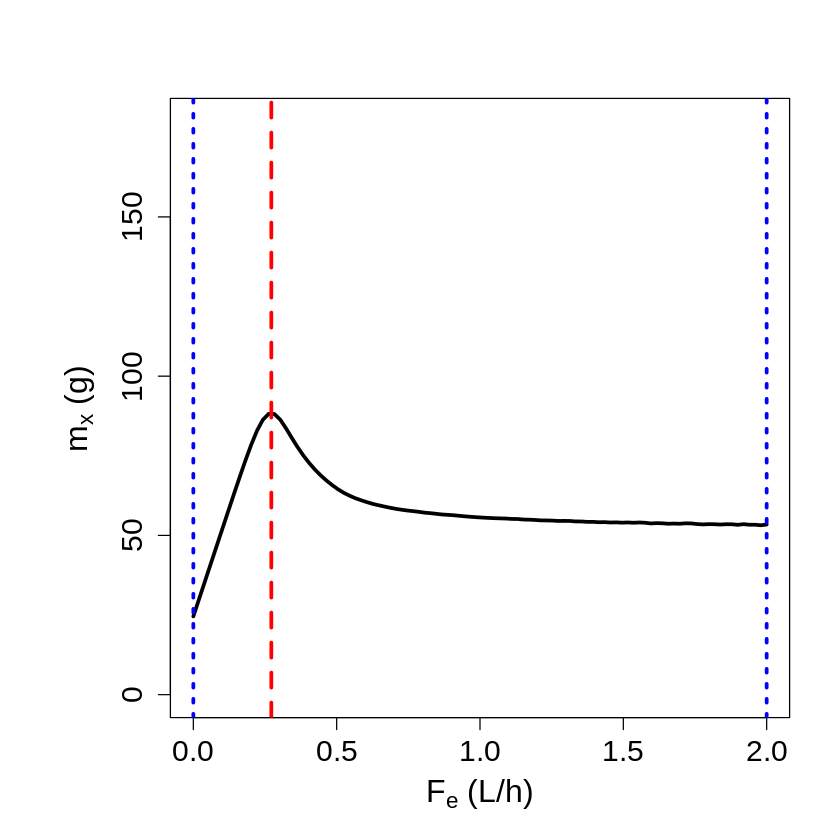

In [107]:
# mostrar resultados de la optimización
par(mar = c(5,7,4,2) + 0.1)
plot(Fin, out_zb_const, ylab = expression(paste(m[x], " (g)")), xlab = expression(paste(F[e], " (L/h)")), 
        #main = paste0("sf = ", p_zb["sf"], " g/L,", " ki = ", p_zb["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,180))
abline(v = GA_zb_const@solution, col="red", lwd = 3, lty = 2)
abline(v = c(0,2), col="blue", lwd = 3, lty = 3)

### Optimización de Fin para *Zygosaccharomyces rouxi*

In [37]:
# parámetros cinéticos óptimos de ZR y parámetros de operación establecidos
# ki = 0.601
p_zr <- c(mu_max = 1.465,ks = 362.378, ki = 0.601, Yxs = 0.193, Ypx = 3.266, sf = 50, Fin = 1, Vl = 60)

In [38]:
# obtener biomasa final para todos los Fin
out_zr_const <- biomass2(times = times, state = s, parms = p_zr, Fin = Fin, model = model)

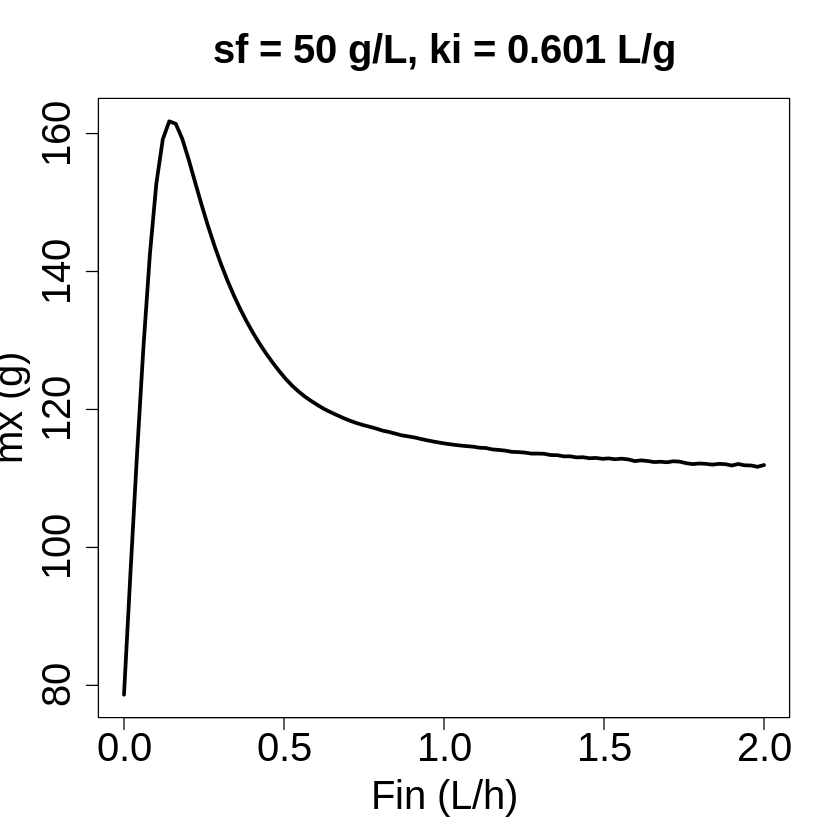

In [39]:
# mostrar función que se va a optimizar 
plot(Fin, out_zr_const, ylab = "mx (g)", xlab = "Fin (L/h)", 
        main = paste0("sf = ", p_zr["sf"], " g/L,", " ki = ", p_zr["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 2, cex.main = 2, cex.axis = 2)

In [40]:
# optimización para encontrar el flujo de alimentación óptimo
set.seed(567)
GA_zr_const <- ga(type = "real-valued",
         fitness = fitness1,
         times= times,
         state = s,
         parms = p_zr,
         model = model,
         lower = 0,
         upper = 2,
         maxiter = 10, 
         popSize = 50, 
         elitism = 2)

In [41]:
# valor Fin que genera la máxima producción de biomasa 
cat("Fin_opt:", GA_zr_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zr_const@fitnessValue, "g")

Fin_opt: 0.1526367  L/h 
mx_opt: 161.8681 g

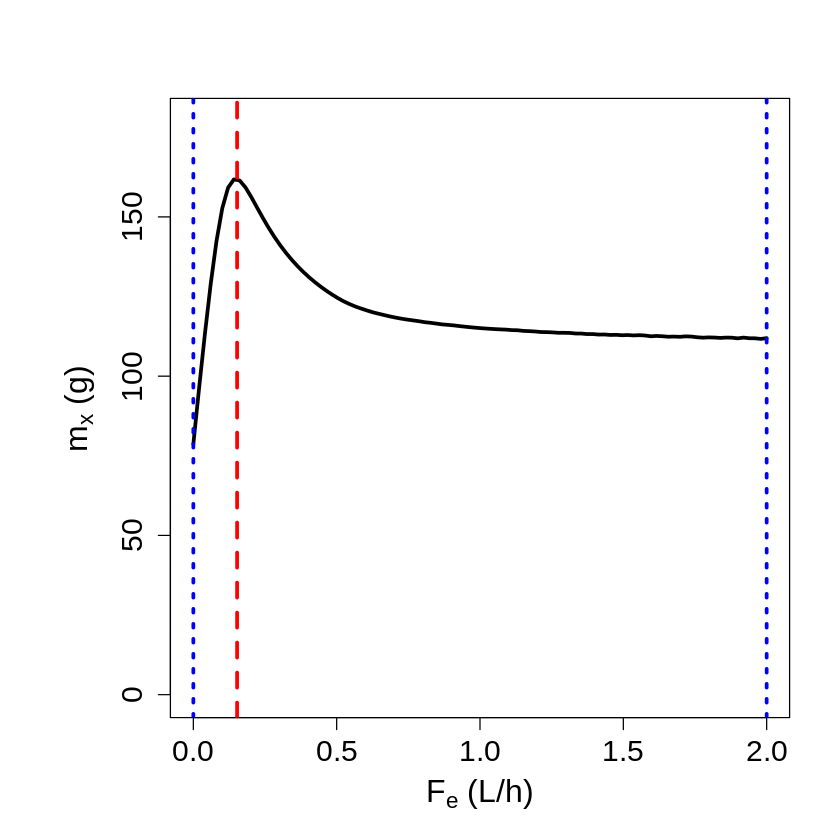

In [108]:
# mostrar resultados de la optimización
par(mar = c(5,7,4,2) + 0.1)
plot(Fin, out_zr_const, ylab = expression(paste(m[x], " (g)")), xlab = expression(paste(F[e], " (L/h)")),  
        #main = paste0("sf = ", p_zr["sf"], " g/L,", " ki = ", p_zr["ki"], " L/g"),
     type = "l", col = 1, lwd = 3, cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,180))
abline(v = GA_zr_const@solution, col="red", lwd = 3, lty = 2)
abline(v = c(0,2), col="blue", lwd = 3, lty = 3)

## Encontrar el perfil de alimentación $F_{in}$ que genera la máxima producción de biomasa, considerando que $V < V_{lim}$

Ahora optimizamos para encontrar el perfil $F_{in}$ que genere una máxima producción de biomasa

In [43]:
# @title función fitness para encontrar el perfil óptimo Fin de alimentación al biorreactor
fitness2 <- function(x, times, state, parms, model, change_input) {
        # x es el vector  con valores de Fin 
        # x tiene una longitud de 10, para hacerlo de tamaño 100 usamos rep()
        Fin <- rep(x, each = 10)
        # simular usando Fin variable 
        out <- change_input(times = times, state = state, parms = parms, Fin = Fin, model = model)
        n <- length(out$V)
        # biomasa generada con el perfil Fin
        mx_end <- out$x[n]*out$V[n]
        
        return(mx_end)
}

### Optimización de perfil Fin para *Isstchenkia terrícola*

In [44]:
# realizar optimización 
set.seed(123)
# para saber cuánto tarda
time1 <- Sys.time()
GA_it <- ga(type = "real-valued",
          fitness = fitness2,
          times= times,
          state = s,
          parms = p_it,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [45]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.596636 mins

In [46]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_it@fitnessValue, "g")

mx_opt: 238.9958 g

In [47]:
# guardar perfil óptimo
Fin_opt_it <- rep(GA_it@solution, each = 10)

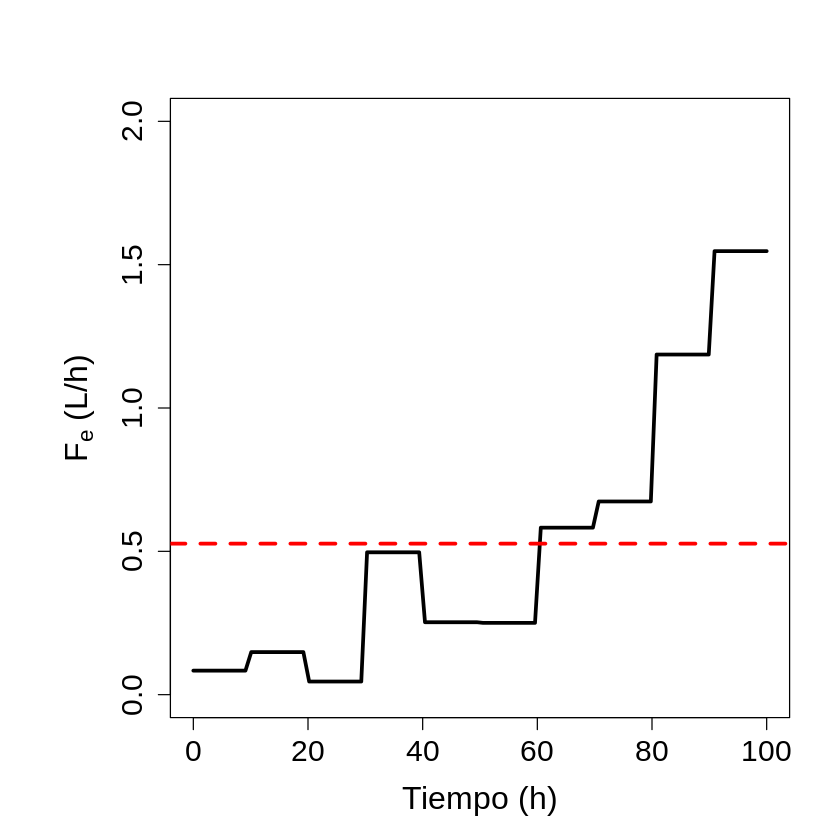

In [109]:
# graficar perfil óptimo
par(mar = c(5,7,4,2) + 0.1)
plot(times, Fin_opt_it, type = "l", lwd = 3, 
    ylab = expression(paste(F[e], " (L/h)")), xlab = "Tiempo (h)", cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,2))
abline(h = mean(Fin_opt_it), lty = 2, lwd = 3, col = "red")


### Optimización del perfil Fin para *Kluyveromyces marxianus*

In [49]:
# realizar optimización 
set.seed(234)
# para saber cuánto tarda
time1 <- Sys.time()
GA_km <- ga(type = "real-valued",
          fitness = fitness2,
          times= times,
          state = s,
          parms = p_km,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [50]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.764171 mins

In [51]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_km@fitnessValue, "g")

mx_opt: 185.3076 g

In [52]:
# guardar perfil óptimo
Fin_opt_km <- rep(GA_km@solution[1,], each = 10)

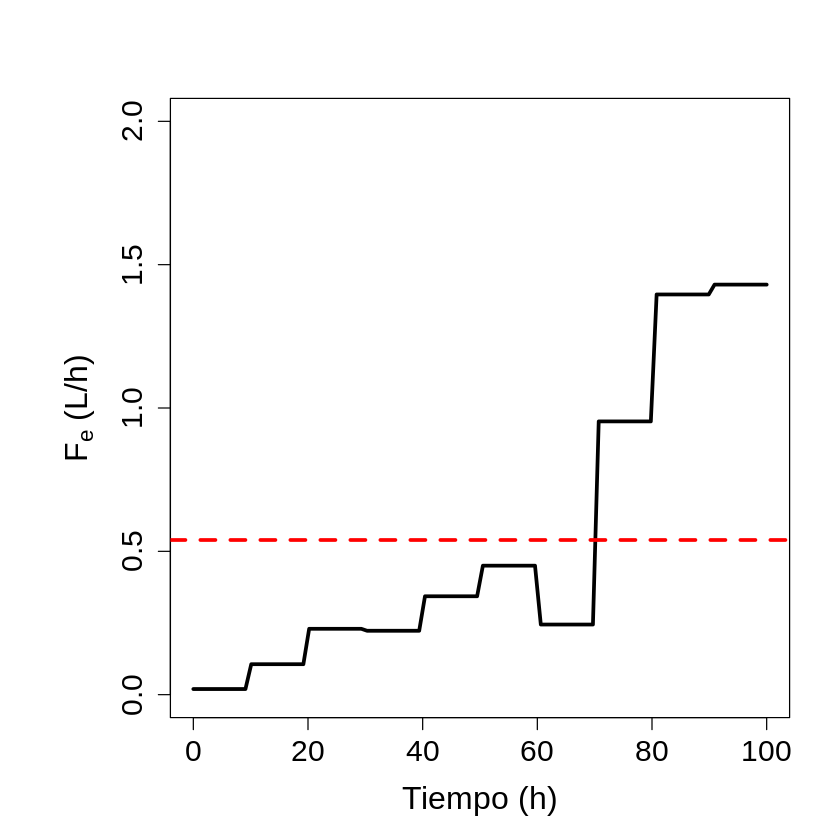

In [110]:
# graficar perfil óptimo
par(mar = c(5,7,4,2) + 0.1)
plot(times, Fin_opt_km, type = "l", lwd = 3, 
    ylab = expression(paste(F[e], " (L/h)")), xlab = "Tiempo (h)", cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,2))
abline(h = mean(Fin_opt_km), lty = 2, lwd = 3, col = "red")

### Optimización de perfil Fin para *Pichia kluyveri*

In [54]:
# realizar optimización 
set.seed(345)
# para saber cuánto tarda
time1 <- Sys.time()
GA_pk <- ga(type = "real-valued",
          fitness = fitness2,
          times= times,
          state = s,
          parms = p_pk,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [55]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.742938 mins

In [56]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_pk@fitnessValue, "g")

mx_opt: 183.5119 g

In [57]:
# guardar perfil óptimo
Fin_opt_pk <- rep(GA_pk@solution, each = 10)

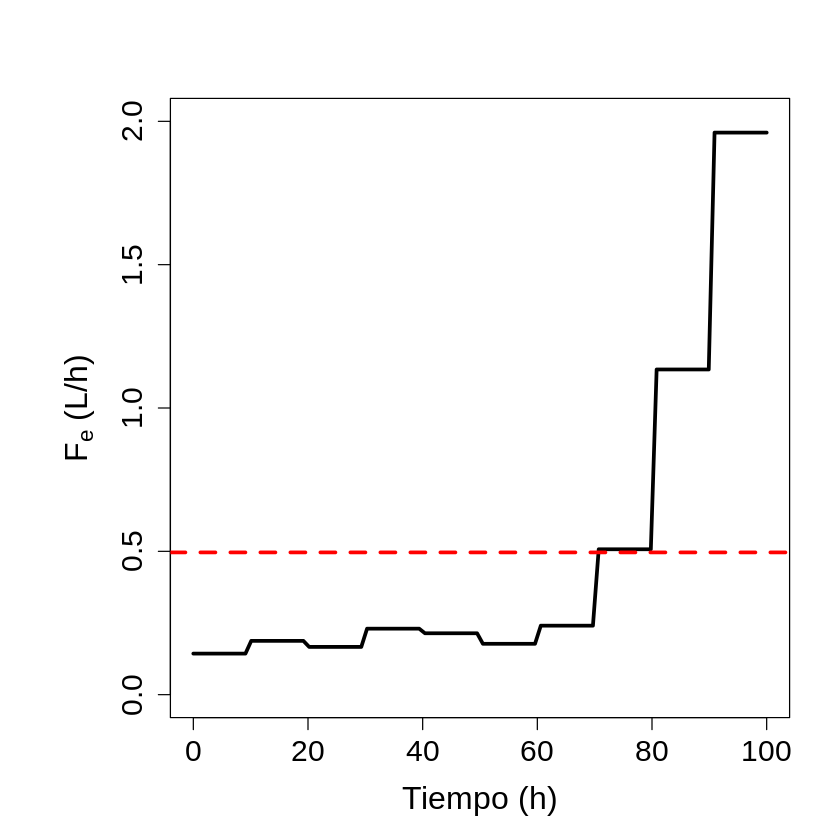

In [111]:
# graficar perfil óptimo
par(mar = c(5,7,4,2) + 0.1)
plot(times, Fin_opt_pk, type = "l", lwd = 3, 
    ylab = expression(paste(F[e], " (L/h)")), xlab = "Tiempo (h)", cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,2))
abline(h = mean(Fin_opt_pk), lty = 2, lwd = 3, col = "red")

### Optimización de perfil Fin para *Zygosaccharomyces bailii*

In [59]:
# realizar optimización 
set.seed(456)
# para saber cuánto tarda
time1 <- Sys.time()
GA_zb <- ga(type = "real-valued",
          fitness = fitness2,
          times= times,
          state = s,
          parms = p_zb,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [60]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.766399 mins

In [61]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_zb@fitnessValue, "g")

mx_opt: 116.4356 g

In [62]:
# guardar perfil óptimo
Fin_opt_zb <- rep(GA_zb@solution[1,], each = 10)

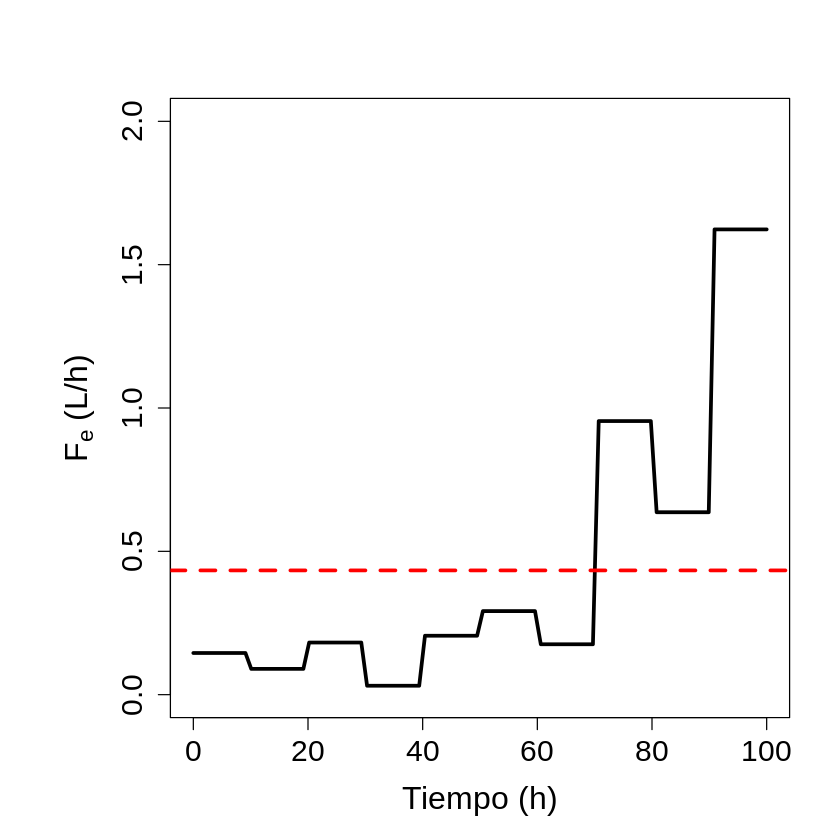

In [112]:
# graficar perfil óptimo
par(mar = c(5,7,4,2) + 0.1)
plot(times, Fin_opt_zb, type = "l", lwd = 3, 
    ylab = expression(paste(F[e], " (L/h)")), xlab = "Tiempo (h)", cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,2))
abline(h = mean(Fin_opt_zb), lty = 2, lwd = 3, col = "red")

### Optimización de Fin para *Zygosaccharomyces rouxi*

In [64]:
# realizar optimización 
set.seed(567)
# para saber cuánto tarda
time1 <- Sys.time()
GA_zr <- ga(type = "real-valued",
          fitness = fitness2,
          times= times,
          state = s,
          parms = p_zr,
          model = model,
          change_input = change_input,
          lower = rep(0, 10),
          upper = rep(2, 10),
         maxiter = 100, 
         popSize = 50, 
         elitism = 2)
time2 <- Sys.time()

In [65]:
# tiempo que toma hacer la optimización
time2 - time1

Time difference of 3.748271 mins

In [66]:
# valor máximo de biomasa que se obtuvo
cat("mx_opt:", GA_zr@fitnessValue, "g")

mx_opt: 179.0547 g

In [67]:
# guardar perfil óptimo
Fin_opt_zr <- rep(GA_zr@solution, each = 10)

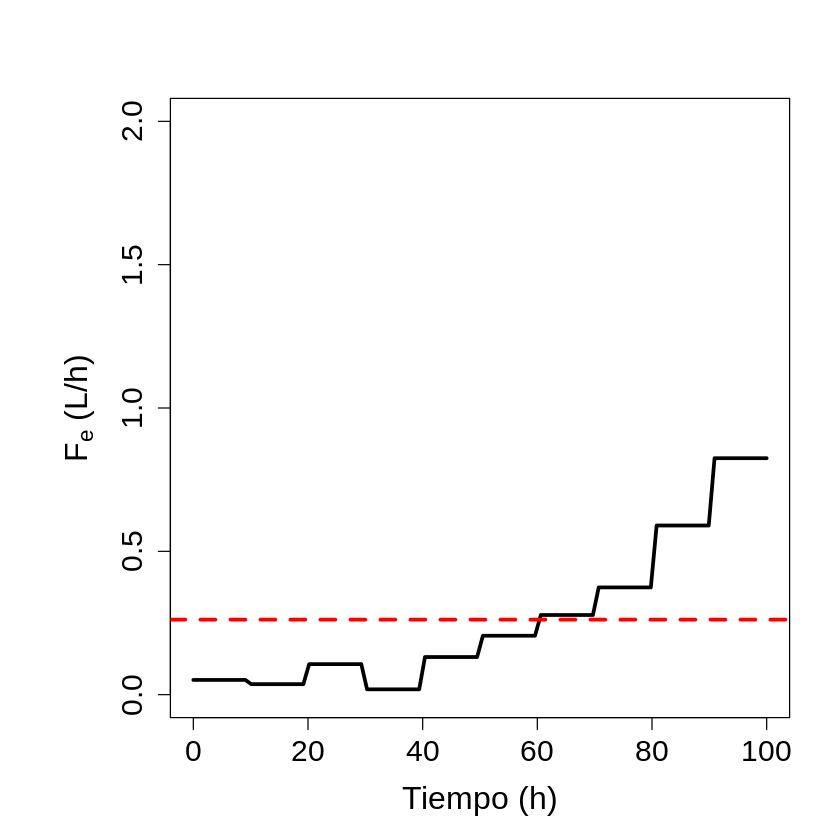

In [113]:
# graficar perfil óptimo
par(mar = c(5,7,4,2) + 0.1)
plot(times, Fin_opt_zr, type = "l", lwd = 3, 
    ylab = expression(paste(F[e], " (L/h)")), xlab = "Tiempo (h)", cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,2))
abline(h = mean(Fin_opt_zr), lty = 2, lwd = 3, col = "red")

# Resultados 

|levadura |	$F_{in}$ óptimo	| $m_{x}$ generado|
|:---:|:---:|:---:|
| IT | 0.357 L/h | 177.078 g |
| IT | 0.5268 | 238.9958 g |
| KM | 0.390 L/h | 139.374 g |
| KM | 0.539 | 185.3076 g |
| PK | 0.290 L/h | 140.656 g |
| PK | 0.496 | 183.5119 g |
| ZB | 0.272 L/h | 88.375 g |
| ZB | 0.433 | 116.4356 g |
| ZR | 0.1526 L/h | 161.868 g |
| ZR | 0.2617 | 179.0547 g |

In [70]:
# @title valor Fin que genera la máxima producción de biomasa 
cat("IT: \n")
cat("Fin_opt:", GA_it_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_it_const@fitnessValue, "g","\n")
cat("KM: \n")
cat("Fin_opt:", GA_km_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_km_const@fitnessValue, "g","\n")
cat("PK: \n")
cat("Fin_opt:", GA_pk_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_pk_const@fitnessValue, "g","\n")
cat("ZB: \n")
cat("Fin_opt:", GA_zb_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zb_const@fitnessValue, "g","\n")
cat("ZR: \n")
cat("Fin_opt:", GA_zr_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zr_const@fitnessValue, "g","\n")


IT: 
Fin_opt: 0.3572084  L/h 
mx_opt: 177.0786 g 
KM: 
Fin_opt: 0.3900033  L/h 
mx_opt: 139.3746 g 
PK: 
Fin_opt: 0.2906421  L/h 
mx_opt: 140.6564 g 
ZB: 
Fin_opt: 0.2720675  L/h 
mx_opt: 88.37581 g 
ZR: 
Fin_opt: 0.1526367  L/h 
mx_opt: 161.8681 g 


In [71]:
# @title máxima producción de biomasa generada con el perfil Fe 
cat("IT: \n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_it@fitnessValue, "g","\n")
cat("KM: \n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_km@fitnessValue, "g","\n")
cat("PK: \n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_pk@fitnessValue, "g","\n")
cat("ZB: \n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zb@fitnessValue, "g","\n")
cat("ZR: \n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zr@fitnessValue, "g","\n")

IT: 
mx_opt: 238.9958 g 
KM: 
mx_opt: 185.3076 g 
PK: 
mx_opt: 183.5119 g 
ZB: 
mx_opt: 116.4356 g 
ZR: 
mx_opt: 179.0547 g 


In [72]:
data_Fe <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(GA_it_const@fitnessValue,GA_km_const@fitnessValue,GA_pk_const@fitnessValue,GA_zr_const@fitnessValue,GA_zb_const@fitnessValue))

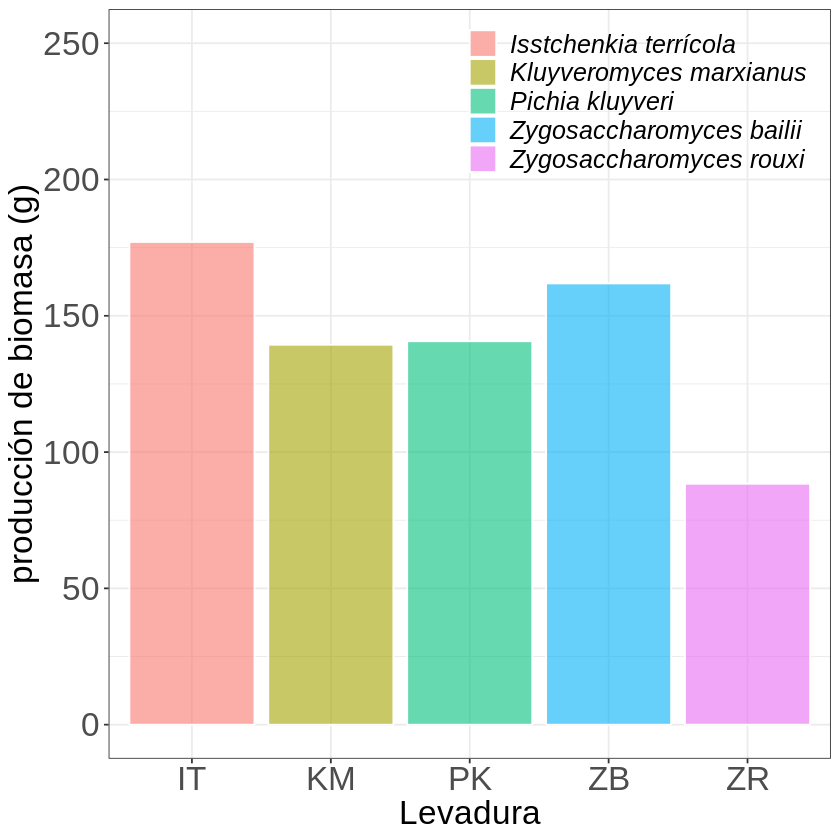

In [73]:
ggplot(data=data_Fe, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("producción de biomasa (g)") +
  ylim(c(0,250))+
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

In [74]:
data_profil <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(GA_it@fitnessValue, GA_km@fitnessValue, GA_pk@fitnessValue, GA_zr@fitnessValue, GA_zb@fitnessValue))

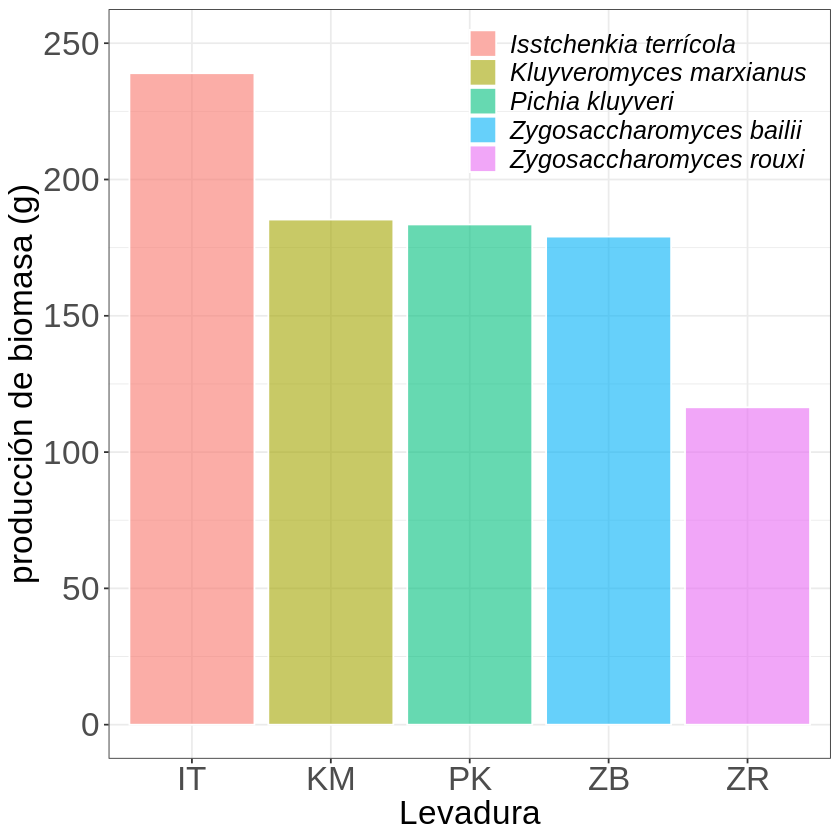

In [75]:
ggplot(data=data_profil, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("producción de biomasa (g)") +
  ylim(c(0,250))+
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

In [79]:
# Perfil óptimo promedio 
cat("IT:")
print(mean(Fin_opt_it))
cat("KM:")
print(mean(Fin_opt_km))
cat("PK:")
print(mean(Fin_opt_pk))
cat("ZB:")
print(mean(Fin_opt_zb))
cat("ZR:")
print(mean(Fin_opt_zr))

IT:[1] 0.5268323
KM:[1] 0.5396129
PK:[1] 0.4962639
ZB:[1] 0.4335066
ZR:[1] 0.2617187
